# Deep Recurrent Q-learning for POMDP

https://arxiv.org/pdf/1507.06527.pdf

#### Guillaume Berger

#### The limit of Deep Q-Networks

*Deep Q-Networks (DQNs)* have recently known great successes, especially with Atari 2600 games, on which they achieved state-of-the-art results [2, 3]. A DQN agent is learning policies from raw pixels exploiting a CNN trained via Q-Learning. Although training such agents is hard, long, and requires some tricks (Experience Replay, Target network...), obtained policies are above or near-human performance on many Atari games.

However, DQNs are limited: they take decisions from a fixed number of past observations. More concretely, a DQN agent trained on an Atari game usually takes its decisions based on the last four observed frames:

<img src="imgs/DQN_.png", width=600>

Due to its limited receptive field over past interactions, such agent would not be able to master tasks in wich it is important to remember information from early timesteps. On Atari games, it does not really matter because knowing only the last 4 frames is most of the time sufficient to determine the optimal policy. In other words, for Atari games, including the last four observed frames in the state representation is enough to make the environment be Markovian. Nevertheless, we could easily imagine games, or real-word applications, where it would be important for the agent to store memories of past interactions in order to determine a more clever long-term strategy. A DQN, as presented in the previous figure, would not be well equiped for this kind of task. 

#### Partial Observability

Unfortunately, in most real-world applications, the entire world is not visible at any moment, but partially observable. *[add example]*. In this context, the environment does not meet the standards of a Markovian Decision Process (MDP) because the current state is not sufficient to select the optimal policy: we talk of Partialy Observable Markov Decision Processes (POMDPs). In order to master POMDPs, it is important to allow the agent to store (and read from) memories of past interactions. *Deep Recurrent Q-Networks (DRQNs)* [1] offers a way of achieving this.

#### Deep Recurrent Q-Networks

As illustrated below, designing the architecture of a DRQN could simply consist in adding one recurrent layer on top of feedforward ones. In comparison with feedforward layers, recurrent ones have hidden states that are persistent over time:

$$h_{t+1} = \Phi(U \ x_{t+1}  +  W \ h_t) $$

where $h_t$ represents the hidden states, $x_{t+1}$ is the new input at timestep $t+1$, and $\Phi$ is a non-linearity. Therefore, at timestep $T$, the hidden states $h_T$ depends on all previously visited states $h_t, t<T$. Consequently, one can hope that a DRQN agent will be able to exploits past experience via the persistent states of its recurrent layer. Note that, in practice, one would probably prefer LSTM layers, for which the recurrent equation is more complex, over simple recurrent layers as they are better at learning long-term dependencies.  

<img src="imgs/DRQN.png", width=800>

In [1], they compared DQNs and DRQNs, trained on POMDP versions of Atari games. Results illustrate the benefit of incorporating recurrent layers in the architecture of the function approximator: as expected, **DRQNs better handle partial observability**

#### Some related papers

While giving the opportunity of storing memories to the agent is not a novel idea (e.g. [7]), this memory mechanism seems to be a hot topic currently:

-  *Feedback Recurrent Memory Q-Networks (FRMQNs)* [4] obtains promising results on Minecraft tasks. FRMQNs not only exploits recurrent nets, but also Memory Networks [6] which provides another neural mechanism for storing experiences. In comparison with LSTMs, the memory of MemNets is more explicit and compartimentalized.

- The very recent DeepMind paper [5] also investigates a mechanism that allows the agent to store past experiences. However, their memory mechanism seems to be mostly aimed at speeding up the training of DQNs rather than improving performance on POMDPs.

### References

[1] **Deep Recurrent Q-Learning for Partially Observable MDPs**, Matthew Hausknecht and Peter Stone, (2015)

[2] **Playing Atari with Deep Reinforcement Learning**, Volodymyr Mnih, Koray Kavukcuoglu, David Silver, Alex Graves, Ioannis Antonoglou, Daan Wierstra, Martin Riedmiller (2015)

[3] **Asynchronous Methods for Deep Reinforcement Learning**, Volodymyr Mnih, Adrià Puigdomènech Badia1, Mehdi Mirza1, Alex Graves, Tim Harley, Timothy P., David Silver, Koray Kavukcuoglu (2016)

[4] **Control of Memory, Active Perception, and Action in Minecraft**, Junhyuk Oh, Valliappa Chockalingam, Satinder Singh, Honglak Lee (2016)

[5] **Neural Episodic Control**, Alexander Pritzel, Benigno Uria, Sriram Srinivasan, Adria Puigdom, Oriol Vinyals, Demis Hassabis, Daan Wierstra, Charles Blundell (2017)

[6] **End-To-End Memory Networks**, Sainbayar Sukhbaatar, Arthur Szlam, Jason Weston, Rob Fergus (2015)
 
[7]  **Sparse Distributed Memories for On-Line Value-Based Reinforcement Learning**, Bohdana Ratitch, Doina Precup (2004)

# EXPERIMENTs

You'll find below the results of DQN/RDQN on a GridWorld POMDP taken from this cool blog post: https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-6-partial-observability-and-deep-recurrent-q-68463e9aeefc

I also re-use some parts of my code done for assignment 2 on DQNs (https://github.com/rllabmcgill/rlcourse-march-17-guillaumebrg). The code uses Keras v1 and has been tested with a Theano backend.

### Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pickle

import dqn
import utils
import deepnets

Using Theano backend.
Using gpu device 0: GeForce GTX 850M (CNMeM is disabled, cuDNN 5005)


# A Gridworld example

**Rules**: the agent (blue) evolves in a Gridworld. When the agent moves on a green cell, the reward is **+0.5**. On the contrary, when the agent moves on a red cell, the reward is **-1.0**. For any other move, the reward is **-0.1**. When a green cell is reached, it re-appears elsewhere.

Inspired from https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-6-partial-observability-and-deep-recurrent-q-68463e9aeefc

### Demo

In [17]:
environment_demo = dqn.demo_GridWorld()

#### Press Ctrl + Enter

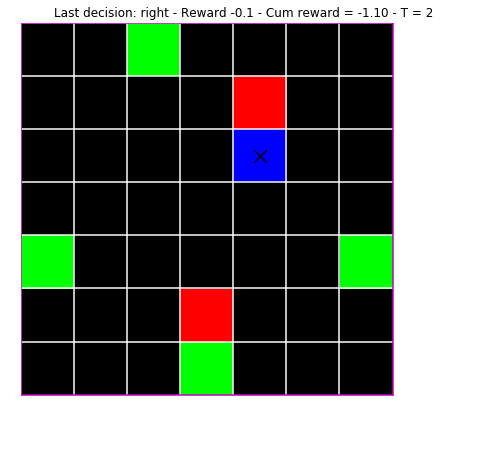

In [28]:
s = next(environment_demo)

# DEBUGGING on a toy example

### The DQN agent class - Random moves with random weights

Just to check that everything works fine...

#### Defining the environment / deep net / experience buffer

In [3]:
epsilon = 0. # Fully stochastic
gamma= 0.95
T = 10

# Environment
environment = dqn.GridWorld(3, 3, 2, 1, T, gamma=gamma)
# A neural net
neuralnet = deepnets.CNN_3x3((3, 3, 3), 0.01)
# ExperienceReplay 
experience_replay = dqn.ExperienceReplay(environment.return_state().shape, 1)

#### The DQN agent

In [17]:
agent = dqn.DQNAgent(environment, neuralnet, experience_replay, 1, epsilon=epsilon, gamma=gamma)

#### Press Ctrl + Enter to make the agent move...

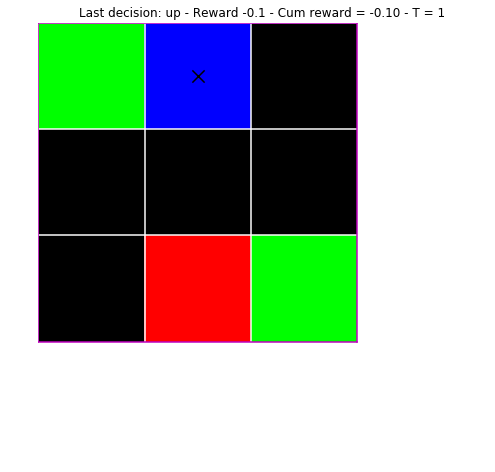

In [34]:
batch, target_batch =  agent.demo()

# Few small experiments on this 3x3 grid

**Nothing to do with POMDPs and DRQNs...** Before experimenting a POMDP and a bigger grid, I wanted to debug/test few things:

- Adam vs SGD
- TargetNet patience = 1 episode vs TargetNet patience = 5 episodes
- Dueling vs No Dueling

**A very small neural net :** 1 hidden layer with 16 neurons and ReLu activation, followed by the linear output layer.

In [29]:
neuralnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=False, adam=False)
neuralnet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 3, 3)       0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 16, 1, 1)      448         input_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 16, 1, 1)      0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 4, 1, 1)       68          activation_1[0][0]               
___________________________________________________________________________________________

### Fixed parameters

In [3]:
epsilon = 0.8 # for epsilon-greedy action selection
gamma= 0.99 # discount factor
batch_size = 32 # nb of samples taken from the experience buffer at each iteration
T = 50 # length of an episode
buffer_size = T*500 # buffer of 500 episodes

### SGD vs Adam

#### SGD

In [57]:
target_patience = 5
# Environment
environment = dqn.GridWorld(3, 3, 2, 1, T, gamma=gamma)
# A neural net
neuralnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=False, adam=False)
targetnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=False, adam=False)
# ExperienceReplay 
experience_replay = dqn.ExperienceReplay(environment.return_state().shape, buffer_size)
# Agent
agent = dqn.DQNAgent(environment, neuralnet, experience_replay, batch_size, target_net=targetnet, 
                     target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)

In [58]:
name = "sgd"
# Train for 100 epochs of 1500 updates
agent.fit(1500, 100, max_q_size=10, savename="experiment_01/weights_%s.npy"%name)
# Save learning curve
agent.save_curve("experiment_01/curve_%s.npy"%name)

Episode 2999 - Running cum reward = 5.204 took 0.3s..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

#### Adam

In [59]:
target_patience = 5
# Environment
environment = dqn.GridWorld(3, 3, 2, 1, T, gamma=gamma)
# A neural net
neuralnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=False, adam=True)
targetnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=False, adam=True)
# ExperienceReplay 
experience_replay = dqn.ExperienceReplay(environment.return_state().shape, buffer_size)
# Agent
agent = dqn.DQNAgent(environment, neuralnet, experience_replay, batch_size, target_net=targetnet, 
                     target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)

In [60]:
name = "adam"
# Train for 75 epochs of 1000 updates
agent.fit(1500, 100, max_q_size=10, savename="experiment_01/weights_%s.npy"%name)
# Save learning curve
agent.save_curve("experiment_01/curve_%s.npy"%name)

Episode 2998 - Running cum reward = -3.603 took 0.4s.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

#### Learning curves

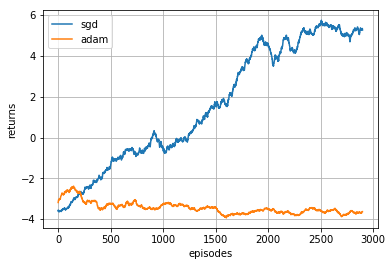

In [34]:
plt.figure()
for name in ["sgd", "adam"]:
    curve = np.load("experiment_01/curve_%s.npy"%name)
    plt.plot(utils.moving_average(curve, 100), label=name)
plt.grid()
plt.legend()
plt.ylabel("returns")
plt.xlabel("episodes")
plt.show()

On this toy example, Adam (=SGD with fancy adaptive learning rate) does not seem to work. I tried to change the learning rate, without success.

### Target patience = 5 vs Target patience = 1

#### Target patience = 1

In [65]:
target_patience = 1
# Environment
environment = dqn.GridWorld(3, 3, 2, 1, T, gamma=gamma)
# A neural net
neuralnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=False, adam=False)
targetnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=False, adam=False)
# ExperienceReplay 
experience_replay = dqn.ExperienceReplay(environment.return_state().shape, 50*500)
# Agent
agent = dqn.DQNAgent(environment, neuralnet, experience_replay, batch_size, target_net=targetnet, 
                     target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)

In [ ]:
name = "target_patience=1"
# Train for 75 epochs of 1000 updates
agent.fit(1500, 100, max_q_size=10, savename="experiment_01/weights_%s.npy"%name)
# Save learning curve
agent.save_curve("experiment_01/curve_%s.npy"%name)

#### Learning curve

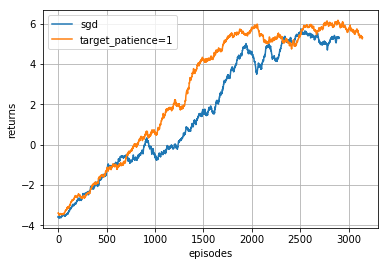

In [35]:
plt.figure()
for name in ["sgd", "target_patience=1"]:
    curve = np.load("experiment_01/curve_%s.npy"%name)
    plt.plot(utils.moving_average(curve, 100), label=name)
plt.grid()
plt.legend()
plt.ylabel("returns")
plt.xlabel("episodes")
plt.show()

Similar performance. I kept using target_patience = 1 in the following.

### Dueling vs No dueling

*Dueling* refers to the decoupling of $Q$ into two estimators : one for the state-value function, one for the "state-action dependent advantage" function:

$$Q(S,A) = V(S) + A(S, A)$$

(see https://arxiv.org/abs/1511.06581)

#### Dueling

In [71]:
target_patience = 1
# Environment
environment = dqn.GridWorld(3, 3, 2, 1, T, gamma=gamma)
# A neural net
neuralnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=True, adam=False)
targetnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=True, adam=False)
# ExperienceReplay 
experience_replay = dqn.ExperienceReplay(environment.return_state().shape, 50*500)
# Agent
agent = dqn.DQNAgent(environment, neuralnet, experience_replay, batch_size, target_net=targetnet, 
                     target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)

In [72]:
name = "dueling"
# Train for 75 epochs of 1000 updates
agent.fit(1500, 100, max_q_size=10, savename="experiment_01/weights_%s.npy"%name)
# Save learning curve
agent.save_curve("experiment_01/curve_%s.npy"%name)

Episode 2999 - Running cum reward = 4.926 took 0.4s..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

#### Learning curve

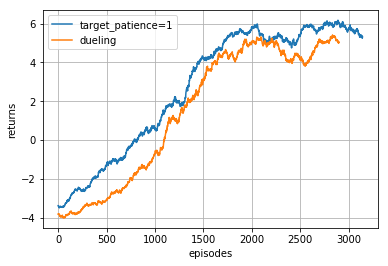

In [36]:
plt.figure()
for name in ["target_patience=1", "dueling"]:
    curve = np.load("experiment_01/curve_%s.npy"%name)
    plt.plot(utils.moving_average(curve, 100), label=name)
plt.grid()
plt.legend()
plt.ylabel("returns")
plt.xlabel("episodes")
plt.show()

I did not use Dueling in the following

### Demo after training

In [357]:
dqn = reload(dqn)

In [358]:
# Environment
environment = dqn.GridWorld(3, 3, 2, 1, T, gamma=gamma)
# A neural net
neuralnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=False, adam=False)
targetnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=False, adam=False)
# ExperienceReplay 
experience_replay = dqn.ExperienceReplay(environment.return_state().shape, 50*500)
# Agent
agent = dqn.DQNAgent(environment, neuralnet, experience_replay, batch_size, target_net=targetnet, 
                     target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)

#### Load weights

In [359]:
agent.load_weights("experiment_01/weights_sgd.npy")

#### Demo

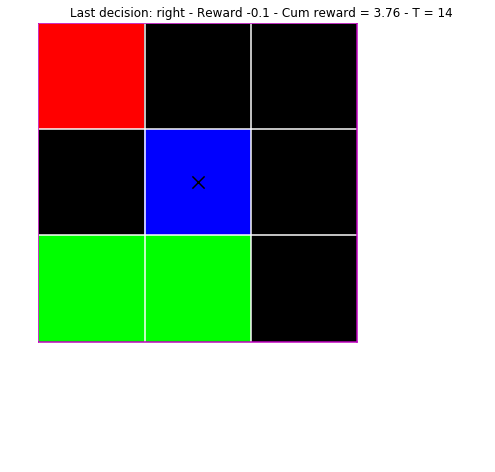

In [497]:
agent.epsilon = 1.
batch, target_batch =  agent.demo()

# Experiment 02 - POMDP - A myopic agent

Let's finally do one experiment with a POMDP.

Here, I consider a 7x7 grid and a **myopic agent**: the agent only sees the 3x3 block of cells centered around its position. Let's compare a DQN and a DRQN on this task.

In [4]:
environment = dqn.GridWorld(7, 7, 5, 3, 50, observable=[3,3], gamma=gamma)

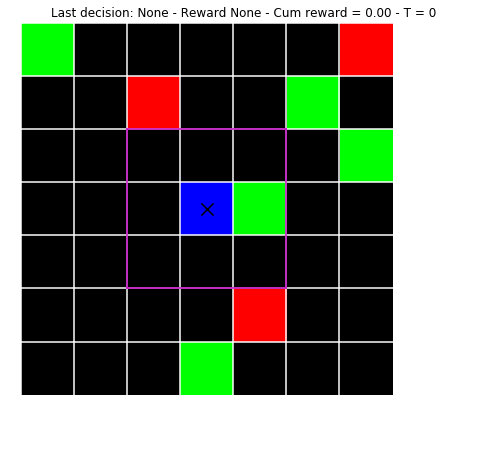

In [5]:
environment.visualize()

### Fixed params

In [4]:
epsilon = 0.8
gamma= 0.99
batch_size = 32
target_patience = 1
buffer_size = 50*500

### DQN

Same neural net as before:

In [30]:
neuralnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=False, adam=False)
neuralnet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 3, 3, 3)       0                                            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 16, 1, 1)      448         input_2[0][0]                    
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 16, 1, 1)      0           convolution2d_3[0][0]            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 4, 1, 1)       68          activation_2[0][0]               
___________________________________________________________________________________________

In [7]:
# Environment
environment = dqn.GridWorld(7, 7, 5, 3, 50, observable=[3,3], gamma=gamma)
# A neural net
neuralnet = deepnets.CNN_3x3((3, 3, 3), 0.001, dueling=False, adam=True)
targetnet = deepnets.CNN_3x3((3, 3, 3), 0.001, dueling=False, adam=True)
# ExperienceReplay 
experience_replay = dqn.ExperienceReplay(environment.return_state().shape, buffer_size)
# Agent
agent = dqn.DQNAgent(environment, neuralnet, experience_replay, batch_size, target_net=targetnet, 
                     target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)

In [8]:
name = "DQN_v2"
# Train for 100 epochs of 1500 updates
agent.fit(1500, 100, max_q_size=10, savename="experiment_02/weights_%s.npy"%name)
# Save learning curve
agent.save_curve("experiment_02/curve_%s.npy"%name)

Episode 0 - Running cum reward = -3.407 took 0.9s.
Episode 10 - Running cum reward = -3.433 took 0.4s.
Episode 20 - Running cum reward = -3.316 took 0.3s.
Episode 30 - Running cum reward = -3.041 took 0.4s.
Episode 40 - Running cum reward = -2.848 took 0.3s.
Episode 50 - Running cum reward = -2.728 took 0.3s.
Episode 60 - Running cum reward = -2.713 took 0.4s.
Episode 70 - Running cum reward = -2.553 took 0.3s.
Episode 80 - Running cum reward = -2.447 took 0.4s.
Episode 90 - Running cum reward = -2.465 took 0.3s.
Episode 100 - Running cum reward = -2.412 took 0.4s.
Episode 110 - Running cum reward = -2.368 took 0.3s.
Episode 120 - Running cum reward = -2.541 took 0.4s.
Episode 130 - Running cum reward = -2.467 took 0.4s.
Episode 140 - Running cum reward = -2.246 took 0.4s.
Episode 150 - Running cum reward = -2.228 took 0.4s.
Episode 160 - Running cum reward = -2.036 took 0.3s.
Episode 170 - Running cum reward = -2.034 took 0.4s.
Episode 180 - Running cum reward = -1.959 took 0.4s.
Epis

### DRQN

Our recurrent net: 1 LSTM layer + Output layer

In [153]:
neuralnet = deepnets.RCNN_3x3((batch_size, 1, 27), 0.01)
neuralnet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (32, 1, 27)           0                                            
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (32, 1, 16)           2816        input_1[0][0]                    
____________________________________________________________________________________________________
timedistributed_1 (TimeDistribut (32, 1, 4)            68          lstm_1[0][0]                     
Total params: 2,884
Trainable params: 2,884
Non-trainable params: 0
____________________________________________________________________________________________________


In [193]:
dqn = reload(dqn)

In [194]:
rec_depth = 50
# Environment
environment = dqn.GridWorld(7, 7, 5, 3, 50, observable=[3,3], gamma=gamma)
# A neural net
neuralnet = deepnets.stateful_RCNN_3x3((batch_size, 1, 27), 0.01)
neuralnet_copy = deepnets.stateful_RCNN_3x3((batch_size, 1, 27), 0.01)
targetnet = deepnets.stateful_RCNN_3x3((batch_size, 1, 27), 0.01)
# ExperienceReplay 
experience_replay = dqn.TemporalExperienceReplay(rec_depth, environment.return_state().shape, buffer_size)
# Agent
agent = dqn.StatefulRDQNAgent(environment, neuralnet, neuralnet_copy, experience_replay, batch_size, target_net=targetnet, 
                     target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)

In [ ]:
name = "DRQN"
# Train for 100 epochs of 1500 updates
agent.fit(1500, 100, max_q_size=10, savename="experiment_02/weights_%s.npy"%name)
# Save learning curve
agent.save_curve("experiment_02/curve_%s.npy"%name)

**Note**: I'm pretty sure that my DRQN implementation is not optimal in terms of speed... $10\times$ slower in comparison with my DQN code. I'll investigate this.

### Stack DQN

In [9]:
# A neural net
# Environment
environment = dqn.GridWorld(7, 7, 5, 3, 50, observable=[3,3], gamma=gamma)
# A neural net
neuralnet = deepnets.CNN_3x3((33, 3, 3), 0.001, dueling=False, adam=True)
targetnet = deepnets.CNN_3x3((33, 3, 3), 0.001, dueling=False, adam=True)
# ExperienceReplay 
#experience_replay = dqn.ExperienceReplay(environment.return_state().shape, buffer_size)
# Agent
#agent = dqn.DQNAgent(environment, neuralnet, experience_replay, batch_size, target_net=targetnet, 
#                     target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)
# ExperienceReplay
experience_replay = dqn.TemporalExperienceReplay(50, environment.return_state().shape, buffer_size, memory=10)
# Agent
agent = dqn.DQNAgent(environment, neuralnet, experience_replay, batch_size, target_net=targetnet, 
                     target_net_patience=target_patience, epsilon=epsilon, gamma=gamma, stack=10)
name = "stackDQN_adam"

# Train for 100 epochs of 1500 updates
agent.fit(1500, 100, max_q_size=10, savename="experiment_02/weights_%s.npy"%name)
# Save learning curve
agent.save_curve("experiment_02/curve_%s.npy"%name)

Episode 0 - Running cum reward = -3.021 took 1.0s.
Episode 10 - Running cum reward = -3.129 took 0.5s.
Episode 20 - Running cum reward = -3.150 took 0.4s.
Episode 30 - Running cum reward = -3.151 took 0.4s.
Episode 40 - Running cum reward = -2.831 took 0.4s.
Episode 50 - Running cum reward = -2.697 took 0.4s.
Episode 60 - Running cum reward = -2.479 took 0.5s.
Episode 70 - Running cum reward = -2.422 took 0.5s.
Episode 80 - Running cum reward = -2.475 took 0.4s.
Episode 90 - Running cum reward = -2.381 took 0.4s.
Episode 100 - Running cum reward = -2.448 took 0.5s.
Episode 110 - Running cum reward = -2.311 took 0.4s.
Episode 120 - Running cum reward = -2.163 took 0.4s.
Episode 130 - Running cum reward = -2.073 took 0.4s.
Episode 140 - Running cum reward = -2.022 took 0.4s.
Episode 150 - Running cum reward = -2.152 took 0.4s.
Episode 160 - Running cum reward = -2.166 took 0.4s.
Episode 170 - Running cum reward = -2.204 took 0.4s.
Episode 180 - Running cum reward = -2.185 took 0.4s.
Epis

#### DRMQN

In [19]:
deepnets = reload(deepnets)

In [20]:
rec_depth = 50
# Environment
environment = dqn.GridWorld(7, 7, 5, 3, 50, observable=[3,3], gamma=gamma)
# A neural net
neuralnet = deepnets.stateful_RMCNN_3x3((32, 3, 3, 3), (32, 10, 3, 3, 3), 0.01, adam=True)
neuralnet_copy = deepnets.stateful_RMCNN_3x3((32, 3, 3, 3), (32, 10, 3, 3, 3), 0.01, adam=True)
targetnet = deepnets.stateful_RMCNN_3x3((32, 3, 3, 3), (32, 10, 3, 3, 3), 0.01, adam=True)
# ExperienceReplay 
experience_replay = dqn.TemporalExperienceReplay(rec_depth, environment.return_state().shape, buffer_size, memory=10)
# Agent
agent = dqn.StatefulDRMQNAgent(environment, neuralnet, neuralnet_copy, experience_replay, batch_size, target_net=targetnet, 
                               flatten=False, target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)

In [ ]:
name = "DRMQN"

# Train for 100 epochs of 1500 updates
agent.fit(1500, 100, max_q_size=1, savename="experiment_02/weights_%s.npy"%name)
# Save learning curve
agent.save_curve("experiment_02/curve_%s.npy"%name)

Episode 0 - Running cum reward = -3.974 took 11.1s.
Episode 10 - Running cum reward = -3.866 took 4.5s.
Episode 20 - Running cum reward = -3.826 took 5.0s.
Episode 30 - Running cum reward = -3.798 took 4.9s.
Episode 40 - Running cum reward = -3.713 took 4.7s.
Episode 50 - Running cum reward = -3.539 took 4.6s.
Episode 60 - Running cum reward = -3.408 took 4.5s.
Episode 70 - Running cum reward = -3.269 took 4.6s.
Episode 80 - Running cum reward = -3.007 took 4.5s.
Episode 90 - Running cum reward = -2.897 took 4.4s.
Episode 100 - Running cum reward = -2.615 took 4.3s.
Episode 110 - Running cum reward = -2.624 took 4.2s.
Episode 120 - Running cum reward = -2.448 took 4.3s.
Episode 130 - Running cum reward = -2.392 took 4.3s.
Episode 140 - Running cum reward = -2.366 took 4.7s.
Episode 150 - Running cum reward = -2.197 took 4.6s.
Episode 160 - Running cum reward = -2.087 took 4.7s.
Episode 170 - Running cum reward = -2.045 took 4.6s.
Episode 180 - Running cum reward = -2.157 took 4.5s.
Epi

# Variante

In [1]:
utils = reload(utils)
dqn = reload(dqn)
deepnets = reload(deepnets)

NameError: name 'utils' is not defined

In [ ]:
batch_size = 32
rec_depth = 8
# Environment
environment = dqn.GridWorld(7, 7, 5, 3, 50, observable=[3,3], gamma=gamma)
# A neural net
neuralnet = deepnets.RCNN_3x3((rec_depth, 27), 0.01, adam=True)
stateful_net = deepnets.stateful_RCNN_3x3((1, 1, 27), 0.01)
targetnet = deepnets.RCNN_3x3((rec_depth, 27), 0.01, adam=True)
# ExperienceReplay 
experience_replay = dqn.TemporalExperienceReplay(rec_depth, environment.return_state().shape, buffer_size, stateful=False)
# Agent
agent = dqn.RDQNAgent(environment, neuralnet, stateful_net, experience_replay, batch_size, target_net=targetnet, 
                      target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)

In [236]:
name = "DQN_v2"
# Train for 100 epochs of 1500 updates
#agent.fit(1500, 100, max_q_size=10, savename="experiment_02/weights_%s.npy"%name)
# Save learning curve
#agent.save_curve("experiment_02/curve_%s.npy"%name)

## DQN vs DRQN

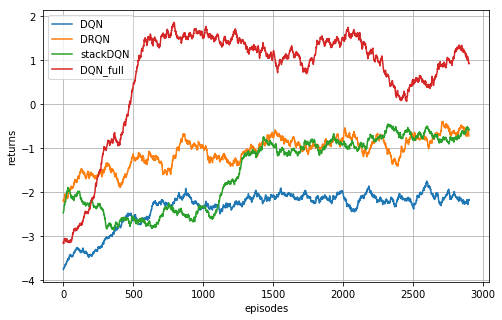

In [15]:
plt.figure(figsize=(8,5))
for name in ["DQN", "DRQN", "stackDQN"]:
    curve = np.load("experiment_02/curve_%s.npy"%name)
    plt.plot(utils.moving_average(curve, 100), label=name)
curve = np.load("experiment_02/curve_DQN_full.npy")
plt.plot(utils.moving_average(curve, 100), label="DQN_full")
plt.grid()
plt.legend()
plt.ylabel("returns")
plt.xlabel("episodes")
plt.show()

As can be seen on the learning curves, the **Recurrent agent clearly outperforms the feedforward one.** To understand why, let's observe how both agents evolve on this task:

### Live demo

In [596]:
# Environment
environment = dqn.GridWorld(7, 7, 5, 3, 50, observable=[3,3], gamma=gamma)
# A neural net
neuralnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=False, adam=False)
targetnet = deepnets.CNN_3x3((3, 3, 3), 0.01, dueling=False, adam=False)
# ExperienceReplay 
experience_replay = dqn.ExperienceReplay(environment.return_state().shape, buffer_size)
# Agent
DQN = dqn.DQNAgent(environment, neuralnet, experience_replay, batch_size, target_net=targetnet, 
                     target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)
# Load weights
DQN.load_weights("experiment_02/weights_DQN.npy")

# Environment
r_environment = dqn.GridWorld(7, 7, 5, 3, 50, observable=[3,3], gamma=gamma)
# A neural net
r_neuralnet = deepnets.RCNN_3x3((batch_size, 1, 27), 0.01)
r_neuralnet_copy = deepnets.RCNN_3x3((batch_size, 1, 27), 0.01)
r_targetnet = deepnets.RCNN_3x3((batch_size, 1, 27), 0.01)
# ExperienceReplay 
t_experience_replay = dqn.TemporalExperienceReplay(rec_depth, environment.return_state().shape, buffer_size)
# Agent
DRQN = dqn.StatefulRDQNAgent(r_environment, r_neuralnet, r_neuralnet_copy, t_experience_replay, batch_size, target_net=r_targetnet, 
                              target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)
DRQN.load_weights("experiment_02/weights_DRQN.npy")

Left: DQN 							Right: DRQN


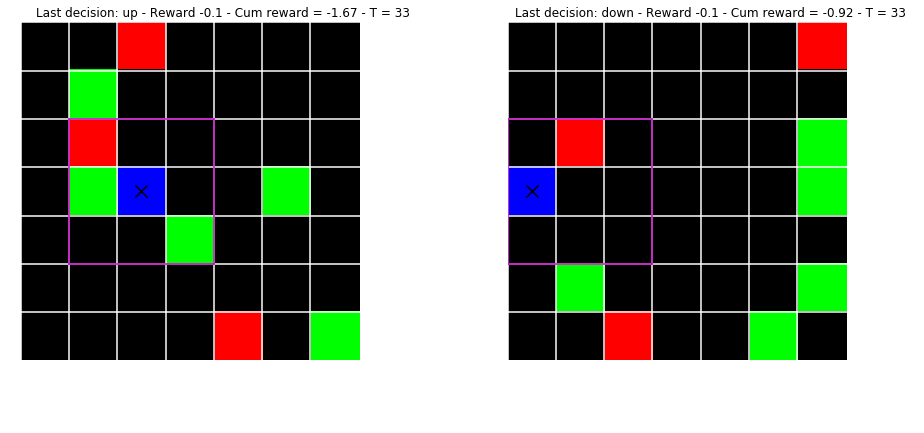

In [1029]:
DQN.epsilon = 1.
DRQN.epsilon = 1.

print("Left: DQN \t\t\t\t\t\t\tRight: DRQN")
plt.figure(figsize=(16,16))
plt.subplot(1,2,1)
batch, target_batch =  DQN.demo(fig=False)
plt.subplot(1,2,2)
batch, target_batch =  DRQN.demo(fig=False)
plt.show()

If you manage to execute the cell above, you'll see that the DQN agent gets often stuck in an infinite loop "left-right-left-right..." (or "up-down-up-down...") when there is no green cell among the visible states. On the contrary, as the DRQN agent is able to remember its past actions, this situation occurs less often with the recurrent agent who is better at discovering green cell in unvisited parts of the grid.

# Experiment 3 -

In [237]:
dqn = reload(dqn)

In [242]:
environment = dqn.GridWorld(7, 7, 5, 3, 50, gamma=0.99, centered=True)

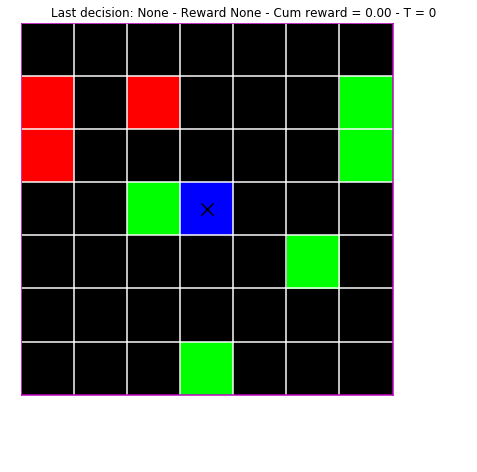

In [243]:
environment.visualize()

### Fully observable

In [2]:
epsilon = 0.8
gamma= 0.99
batch_size = 32
target_patience = 1
buffer_size = 50*500

In [249]:

# Environment
environment = dqn.GridWorld(7, 7, 5, 3, 50, gamma=gamma, centered=True)
# A neural net
neuralnet = deepnets.CNN_7x7((3, 7, 7), 0.01, dueling=False, adam=True)
targetnet = deepnets.CNN_7x7((3, 7, 7), 0.01, dueling=False, adam=True)
# ExperienceReplay 
experience_replay = dqn.ExperienceReplay(environment.return_state().shape, buffer_size)
# Agent
agent = dqn.DQNAgent(environment, neuralnet, experience_replay, batch_size, target_net=targetnet, 
                     target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)

In [250]:
name = "DQN_full"
# Train for 100 epochs of 1500 updates
agent.fit(1500, 100, max_q_size=10, savename="experiment_03/weights_%s.npy"%name)
# Save learning curve
agent.save_curve("experiment_03/curve_%s.npy"%name)

Episode 2999 - Running cum reward = 0.942 took 0.9s.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [273]:
# Environment
environment = dqn.GridWorld(7, 7, 5, 3, 50, gamma=gamma, centered=True, p=0.5)
# A neural net
neuralnet = deepnets.CNN_7x7((3, 7, 7), 0.01, dueling=False, adam=True)
targetnet = deepnets.CNN_7x7((3, 7, 7), 0.01, dueling=False, adam=True)
# ExperienceReplay 
experience_replay = dqn.ExperienceReplay(environment.return_state().shape, buffer_size)
# Agent
agent = dqn.DQNAgent(environment, neuralnet, experience_replay, batch_size, target_net=targetnet, 
                     target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)

In [274]:
neuralnet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_77 (InputLayer)            (None, 3, 7, 7)       0                                            
____________________________________________________________________________________________________
convolution2d_39 (Convolution2D) (None, 16, 3, 3)      448         input_77[0][0]                   
____________________________________________________________________________________________________
activation_31 (Activation)       (None, 16, 3, 3)      0           convolution2d_39[0][0]           
____________________________________________________________________________________________________
convolution2d_40 (Convolution2D) (None, 16, 1, 1)      2320        activation_31[0][0]              
___________________________________________________________________________________________

In [254]:
name = "DQN_p=0.5"
# Train for 100 epochs of 1500 updates
agent.fit(1500, 100, max_q_size=10, savename="experiment_03/weights_%s.npy"%name)
# Save learning curve
agent.save_curve("experiment_03/curve_%s.npy"%name)

Episode 2999 - Running cum reward = -3.968 took 0.9s.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [281]:
neuralnet = deepnets.stateful_RCNN_7x7((32, 3, 7, 7), 0.01, adam=True)

In [282]:
neuralnet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_86 (InputLayer)            (32, 3, 7, 7)         0                                            
____________________________________________________________________________________________________
convolution2d_52 (Convolution2D) (32, 16, 3, 3)        448         input_86[0][0]                   
____________________________________________________________________________________________________
activation_42 (Activation)       (32, 16, 3, 3)        0           convolution2d_52[0][0]           
____________________________________________________________________________________________________
reshape_16 (Reshape)             (32, 1, 144)          0           activation_42[0][0]              
___________________________________________________________________________________________

In [3]:
rec_depth = 50
# Environment
environment = dqn.GridWorld(7, 7, 5, 3, 50, gamma=gamma, centered=True, p=0.5)
# A neural net
neuralnet = deepnets.stateful_RCNN_7x7((batch_size, 3, 7, 7), 0.01, adam=True)
neuralnet_copy = deepnets.stateful_RCNN_7x7((batch_size, 3, 7, 7), 0.01, adam=True)
targetnet = deepnets.stateful_RCNN_7x7((batch_size, 3, 7, 7), 0.01, adam=True)
# ExperienceReplay 
experience_replay = dqn.TemporalExperienceReplay(rec_depth, environment.return_state().shape, buffer_size)
# Agent
agent = dqn.StatefulRDQNAgent(environment, neuralnet, neuralnet_copy, experience_replay, batch_size, target_net=targetnet, 
                              flatten=False, target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)

In [ ]:
name = "RDQN_p=0.5"
# Train for 100 epochs of 1500 updates
agent.fit(1500, 100, max_q_size=10, savename="experiment_03/weights_%s.npy"%name)
# Save learning curve
agent.save_curve("experiment_03/curve_%s.npy"%name)

Episode 1625 - Running cum reward = -2.299 took 1.8s.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

# Experiment 4 - - - -

In [3]:
utils = reload(utils)
dqn = reload(dqn)
deepnets = reload(deepnets)

In [5]:
#neuralnet.summary()

In [4]:
rec_depth = 50
# Environment
environment = dqn.GridWorld(7, 7, 5, 3, 50, gamma=gamma, centered=True, p=0.5)
# A neural net
neuralnet = deepnets.stateful_RMCNN_7x7((32, 3, 7, 7), (32, 10, 3, 7, 7), 0.01, adam=True)
neuralnet_copy = deepnets.stateful_RMCNN_7x7((32, 3, 7, 7), (32, 10, 3, 7, 7), 0.01, adam=True)
targetnet = deepnets.stateful_RMCNN_7x7((32, 3, 7, 7), (32, 10, 3, 7, 7), 0.01, adam=True)
# ExperienceReplay 
experience_replay = dqn.TemporalExperienceReplay(rec_depth, environment.return_state().shape, buffer_size, memory=10)
# Agent
agent = dqn.StatefulDRMQNAgent(environment, neuralnet, neuralnet_copy, experience_replay, batch_size, target_net=targetnet, 
                               flatten=False, target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)

In [ ]:
name = "DRMQN_p=0.5"
# Train for 100 epochs of 1500 updates
agent.fit(1500, 100, max_q_size=10, savename="experiment_03/weights_%s.npy"%name)
# Save learning curve
agent.save_curve("experiment_03/curve_%s.npy"%name)

P =  0.
P =  0.25
P =  0.50
P =  0.75


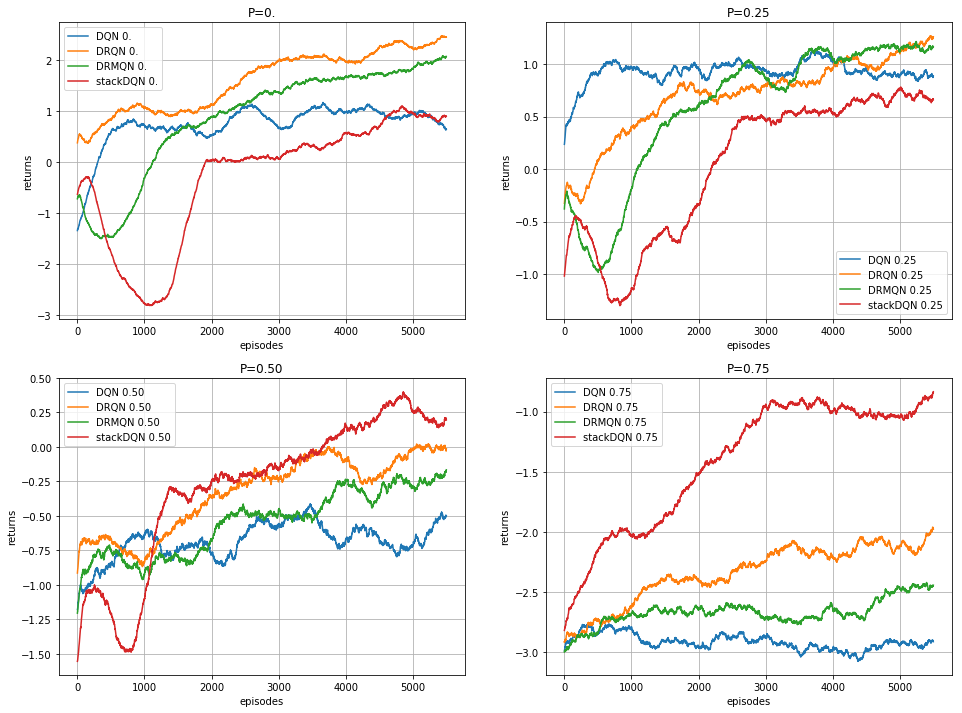

In [63]:
names = ["DQN", "DRQN", "DRMQN", "stackDQN"]

plt.figure(figsize=(16, 12))
i=0

for p in ["0.", "0.25", "0.50", "0.75"]:
    print "P = ", p
    
    plt.subplot(2,2,i+1)
    for name in names:
        try:
            curve = np.load("experiment_03/curve_%s_p=%s_adam.npy"%(name, p))        
            plt.plot(utils.moving_average(curve, 500), label=name + " " + p)
        except:
            pass
    
    plt.title("P=%s"%p)
    plt.grid()
    plt.legend()
    plt.ylabel("returns")
    plt.xlabel("episodes")
    
    i += 1
plt.show()

# Experiments 5

In [8]:
epsilon = 0.8
gamma= 0.99
batch_size = 16
target_patience = 1
buffer_size = 50*500

In [36]:
from imp import reload

In [51]:
dqn = reload(dqn)

In [54]:
# A neural net
# Environment
environment = dqn.GridWorld(7, 7, 5, 3, 50, gamma=gamma, centered=True, p=0.5)
# A neural net
neuralnet = deepnets.CNN_7x7((33, 7, 7), 0.001, dueling=False, adam=True)
targetnet = deepnets.CNN_7x7((33, 7, 7), 0.001, dueling=False, adam=True)
# ExperienceReplay 
#experience_replay = dqn.ExperienceReplay(environment.return_state().shape, buffer_size)
# Agent
#agent = dqn.DQNAgent(environment, neuralnet, experience_replay, batch_size, target_net=targetnet, 
#                     target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)
# ExperienceReplay
experience_replay = dqn.TemporalExperienceReplay(50, environment.return_state().shape, buffer_size, memory=10)
# Agent
agent = dqn.DQNAgent(environment, neuralnet, experience_replay, batch_size, target_net=targetnet, 
                     target_net_patience=target_patience, epsilon=epsilon, gamma=gamma, stack=10)
name = "stackDQN_p=0.50_adam"

# Train for 100 epochs of 1500 updates
agent.fit(3000, 100, max_q_size=1, savename="experiment_03/weights_%s.npy"%name)
# Save learning curve
agent.save_curve("experiment_03/curve_%s.npy"%name)

Episode 0 - Running cum reward = -3.402 took 3.6s.
Episode 10 - Running cum reward = -3.446 took 3.2s.
Episode 20 - Running cum reward = -3.468 took 3.2s.
Episode 30 - Running cum reward = -3.438 took 3.2s.
Episode 40 - Running cum reward = -3.308 took 3.1s.
Episode 50 - Running cum reward = -3.425 took 3.0s.
Episode 60 - Running cum reward = -3.325 took 3.1s.
Episode 70 - Running cum reward = -3.197 took 3.1s.
Episode 80 - Running cum reward = -3.079 took 3.2s.
Episode 90 - Running cum reward = -2.981 took 3.1s.
Episode 100 - Running cum reward = -2.779 took 3.1s.
Episode 110 - Running cum reward = -2.550 took 3.1s.
Episode 120 - Running cum reward = -2.487 took 3.0s.
Episode 130 - Running cum reward = -2.394 took 3.2s.
Episode 140 - Running cum reward = -2.165 took 3.2s.
Episode 150 - Running cum reward = -1.812 took 3.2s.
Episode 160 - Running cum reward = -1.764 took 3.2s.
Episode 170 - Running cum reward = -1.533 took 3.1s.
Episode 180 - Running cum reward = -1.594 took 3.2s.
Epis

KeyboardInterrupt: 

# Robustness to PO

#### Stack

In [30]:
batch_size = 1
# A neural net
# Environment
environment = dqn.GridWorld(7, 7, 5, 3, 50, gamma=gamma, centered=True, p=0.5)
# A neural net
neuralnet = deepnets.CNN_7x7((33, 7, 7), 0.0001, dueling=False, adam=True)
targetnet = deepnets.CNN_7x7((33, 7, 7), 0.0001, dueling=False, adam=True)
# ExperienceReplay
experience_replay = dqn.TemporalExperienceReplay(50, environment.return_state().shape, buffer_size, memory=10)
# Agent
agent = dqn.DQNAgent(environment, neuralnet, experience_replay, batch_size, target_net=targetnet, 
                     target_net_patience=target_patience, epsilon=epsilon, gamma=gamma, stack=10)
agent.load_weights("experiment_03/weights_stackDQN_p=0._adam.npy")

for l in neuralnet.layers:
    l.trainable=False

In [31]:
np.random.seed(123)
agent.fit(500, 50, max_q_size=1, savename="tmp")
print(np.mean(agent.cum_rewards))

Episode 0 - Running cum reward = -1.201 took 7.4s.
Episode 10 - Running cum reward = -1.242 took 3.3s.
Episode 20 - Running cum reward = -1.076 took 3.1s.
Episode 30 - Running cum reward = -0.981 took 3.3s.
Episode 40 - Running cum reward = -0.727 took 3.1s.
Episode 50 - Running cum reward = -0.658 took 3.8s.
Episode 60 - Running cum reward = -0.762 took 3.2s.
Episode 70 - Running cum reward = -0.702 took 3.0s.
Episode 80 - Running cum reward = -0.614 took 3.1s.
Episode 90 - Running cum reward = -0.889 took 3.0s.
Episode 100 - Running cum reward = -0.924 took 3.1s.
Episode 110 - Running cum reward = -0.804 took 3.1s.
Episode 120 - Running cum reward = -0.794 took 3.0s.
Episode 130 - Running cum reward = -0.772 took 3.0s.
Episode 140 - Running cum reward = -0.634 took 3.0s.
Episode 150 - Running cum reward = -0.736 took 3.1s.
Episode 160 - Running cum reward = -0.881 took 3.0s.
Episode 170 - Running cum reward = -1.004 took 3.0s.
Episode 180 - Running cum reward = -1.014 took 3.0s.
Epis

#### DQN

In [32]:
# Environment
environment = dqn.GridWorld(7, 7, 5, 3, 50, gamma=gamma, centered=True, p=0.5)
# A neural net
neuralnet = deepnets.CNN_7x7((3, 7, 7), 0.0001, dueling=False, adam=True)
targetnet = deepnets.CNN_7x7((3, 7, 7), 0.0001, dueling=False, adam=True)
# ExperienceReplay 
experience_replay = dqn.ExperienceReplay(environment.return_state().shape, buffer_size)
# Agent
agent = dqn.DQNAgent(environment, neuralnet, experience_replay, batch_size, target_net=targetnet, 
                     target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)
agent.load_weights("experiment_03/weights_DQN_p=0.00_adam.npy")

for l in neuralnet.layers:
    l.trainable=False

In [33]:
np.random.seed(123)
agent.fit(500, 50, max_q_size=1, savename="tmp")
print(np.mean(agent.cum_rewards))

Episode 0 - Running cum reward = -1.425 took 6.7s.
Episode 10 - Running cum reward = -1.461 took 3.0s.
Episode 20 - Running cum reward = -1.498 took 3.1s.
Episode 30 - Running cum reward = -1.513 took 3.1s.
Episode 40 - Running cum reward = -1.596 took 3.0s.
Episode 50 - Running cum reward = -1.634 took 3.1s.
Episode 60 - Running cum reward = -1.738 took 3.2s.
Episode 70 - Running cum reward = -1.791 took 3.7s.
Episode 80 - Running cum reward = -1.917 took 3.2s.
Episode 90 - Running cum reward = -1.974 took 3.2s.
Episode 100 - Running cum reward = -1.856 took 3.1s.
Episode 110 - Running cum reward = -1.956 took 3.1s.
Episode 120 - Running cum reward = -2.097 took 3.2s.
Episode 130 - Running cum reward = -2.188 took 3.1s.
Episode 140 - Running cum reward = -2.190 took 3.2s.
Episode 150 - Running cum reward = -2.029 took 3.1s.
Episode 160 - Running cum reward = -2.065 took 3.2s.
Episode 170 - Running cum reward = -2.140 took 3.4s.
Episode 180 - Running cum reward = -2.049 took 3.2s.
Epis

#### DRQN

In [34]:
rec_depth = 50
# Environment
environment = dqn.GridWorld(7, 7, 5, 3, 50, gamma=gamma, centered=True, p=0.5)
# A neural net
neuralnet = deepnets.stateful_RCNN_7x7((batch_size, 3, 7, 7), 0.0001, adam=True)
neuralnet_copy = deepnets.stateful_RCNN_7x7((batch_size, 3, 7, 7), 0.0001, adam=True)
targetnet = deepnets.stateful_RCNN_7x7((batch_size, 3, 7, 7), 0.0001, adam=True)
# ExperienceReplay 
experience_replay = dqn.TemporalExperienceReplay(rec_depth, environment.return_state().shape, buffer_size)
# Agent
agent = dqn.StatefulRDQNAgent(environment, neuralnet, neuralnet_copy, experience_replay, batch_size, target_net=targetnet, 
                              flatten=False, target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)
agent.load_weights("experiment_03/weights_DRQN_p=0._adam_v2.npy")

for l in neuralnet.layers:
    l.trainable=False

In [35]:
np.random.seed(123)
agent.fit(500, 50, max_q_size=1, savename="tmp")
print(np.mean(agent.cum_rewards))

Episode 0 - Running cum reward = -1.141 took 12.8s.
Episode 10 - Running cum reward = -1.005 took 5.4s.
Episode 20 - Running cum reward = -0.842 took 5.5s.
Episode 30 - Running cum reward = -0.742 took 5.7s.
Episode 40 - Running cum reward = -0.745 took 5.4s.
Episode 50 - Running cum reward = -0.608 took 5.5s.
Episode 60 - Running cum reward = -0.632 took 5.5s.
Episode 70 - Running cum reward = -0.544 took 5.5s.
Episode 80 - Running cum reward = -0.706 took 6.1s.
Episode 90 - Running cum reward = -0.908 took 5.7s.
Episode 100 - Running cum reward = -0.936 took 5.5s.
Episode 110 - Running cum reward = -0.969 took 5.3s.
Episode 120 - Running cum reward = -0.923 took 5.7s.
Episode 130 - Running cum reward = -0.981 took 5.5s.
Episode 140 - Running cum reward = -0.924 took 5.9s.
Episode 150 - Running cum reward = -0.931 took 5.5s.
Episode 160 - Running cum reward = -0.872 took 5.5s.
Episode 170 - Running cum reward = -0.883 took 5.5s.
Episode 180 - Running cum reward = -0.933 took 5.5s.
Epi

#### DRMQN

In [28]:
rec_depth = 50
# Environment
environment = dqn.GridWorld(7, 7, 5, 3, 50, gamma=gamma, centered=True, p=0.5)
# A neural net
neuralnet = deepnets.stateful_RMCNN_7x7((32, 3, 7, 7), (32, 10, 3, 7, 7), 0.0001, adam=True)
neuralnet_copy = deepnets.stateful_RMCNN_7x7((32, 3, 7, 7), (32, 10, 3, 7, 7), 0.0001, adam=True)
targetnet = deepnets.stateful_RMCNN_7x7((32, 3, 7, 7), (32, 10, 3, 7, 7), 0.0001, adam=True)
# ExperienceReplay 
experience_replay = dqn.TemporalExperienceReplay(rec_depth, environment.return_state().shape, buffer_size, memory=10)
# Agent
agent = dqn.StatefulDRMQNAgent(environment, neuralnet, neuralnet_copy, experience_replay, batch_size, target_net=targetnet, 
                               flatten=False, target_net_patience=target_patience, epsilon=epsilon, gamma=gamma)
agent.load_weights("experiment_03/weights_DRMQN_full_adam.npy")

for l in neuralnet.layers:
    l.trainable=False

In [29]:
np.random.seed(123)
agent.fit(10, 50, max_q_size=1, savename="tmp")
print(np.mean(agent.cum_rewards))

Exception in thread Thread-38:
Traceback (most recent call last):
  File "c:\python27\lib\threading.py", line 810, in __bootstrap_inner
    self.run()
  File "c:\python27\lib\threading.py", line 763, in run
    self.__target(*self.__args, **self.__kwargs)
  File "c:\python27\lib\site-packages\keras-1.2.0-py2.7.egg\keras\engine\training.py", line 409, in data_generator_task
    generator_output = next(generator)
  File "dqn.py", line 411, in qlearning_generator
    target, Q_prime_batch = self.compute_target_and_Qprime(S_batch, S_prime_batch, A_batch, R_batch, T_batch, M_batch)
  File "dqn.py", line 646, in compute_target_and_Qprime
    Q_batch = self.DQN_copy.predict([S_batch, M_batch])
  File "c:\python27\lib\site-packages\keras-1.2.0-py2.7.egg\keras\engine\training.py", line 1220, in predict
    batch_size=batch_size, verbose=verbose)
  File "c:\python27\lib\site-packages\keras-1.2.0-py2.7.egg\keras\engine\training.py", line 898, in _predict_loop
    batch_outs = f(ins_batch)
  File 

ValueError: output of generator should be a tuple (x, y, sample_weight) or (x, y). Found: None